In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import keras.regularizers as regularizers
from keras.regularizers import l2

In [ ]:
import os
import shutil
import numpy as np

# the base directory
base_dir = '/content/drive/MyDrive/datasets/Cervical cancer image dataset'

# directories for training, validation, and testing
train_dir = '/content/data/train'
val_dir = '/content/data/validation'
test_dir = '/content/data/test'

# subdirectories for each class in each set
classes = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Spliting the data
def split_data(base_dir, train_dir, val_dir, test_dir, classes, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        np.random.shuffle(files)

        train_count = int(len(files) * train_ratio)
        val_count = int(len(files) * val_ratio)

        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        for f in train_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(train_dir, cls, f))

        for f in val_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(val_dir, cls, f))

        for f in test_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(test_dir, cls, f))

split_data(base_dir, train_dir, val_dir, test_dir, classes)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_width, img_height = 224, 224
batch_size = 16
base_learning_rate = 0.001  # Adjust as needed

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data preprocessing for test
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [ ]:
# Load the data using data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=True  # Shuffle the data
)
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in train dataset.")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in test dataset.")

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {val_generator.samples} images belonging to {len(val_generator.class_indices)} classes in validation dataset.")

Found 673 images belonging to 4 classes.
Found 673 images belonging to 4 classes in train dataset.
Found 100 images belonging to 4 classes.
Found 100 images belonging to 4 classes in test dataset.
Found 189 images belonging to 4 classes.
Found 189 images belonging to 4 classes in validation dataset.


In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x) we can add dropouts if model is overfitting
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'conv4_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pre

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Compile the model after unfreezing layers for fine-tuning
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
    optimizer=RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
)

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/25
43/43 [==============================] - 70s 1s/step - loss: 0.3238 - accuracy: 0.8990 - val_loss: 0.7580 - val_accuracy: 0.8307 - lr: 1.0000e-04
Epoch 2/25
43/43 [==============================] - 56s 1s/step - loss: 0.2139 - accuracy: 0.9391 - val_loss: 0.3756 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 3/25
43/43 [==============================] - 63s 1s/step - loss: 0.2324 - accuracy: 0.9361 - val_loss: 0.2822 - val_accuracy: 0.9365 - lr: 1.0000e-04
Epoch 4/25
43/43 [==============================] - 57s 1s/step - loss: 0.1520 - accuracy: 0.9480 - val_loss: 0.0913 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 5/25
43/43 [==============================] - 56s 1s/step - loss: 0.2277 - accuracy: 0.9406 - val_loss: 0.0675 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 6/25
43/43 [==============================] - 56s 1s/step - loss: 0.1352 - accuracy: 0.9643 - val_loss: 0.1026 - val_accuracy: 0.9841 - lr: 1.0000e-04
Epoch 7/25
43/43 [==============================] - 58s 1s

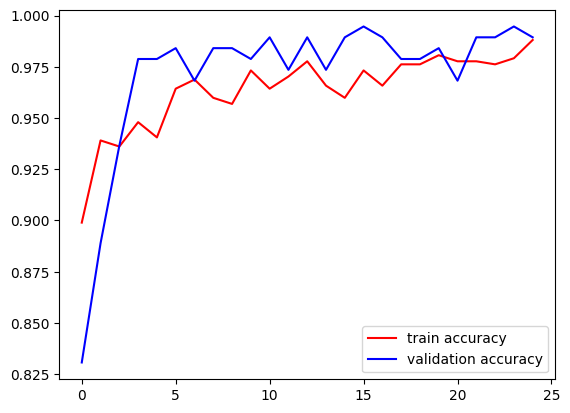

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

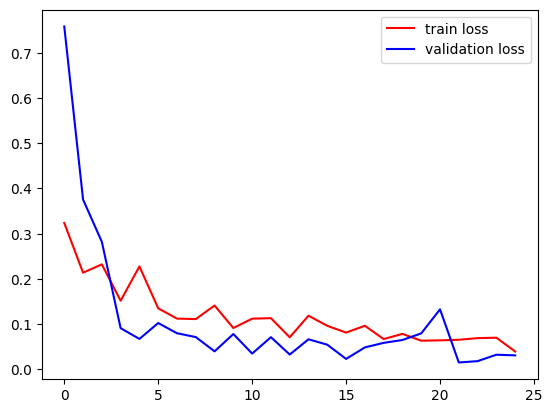

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], color='red', label='train loss')
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

43/43 [==============================] - 42s 966ms/step - loss: 0.0165 - accuracy: 0.9985
Train accuracy: 0.9985


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 8s 1s/step - loss: 0.0870 - accuracy: 0.9600
Test accuracy: 0.9600


7/7 [==============================] - 7s 933ms/step


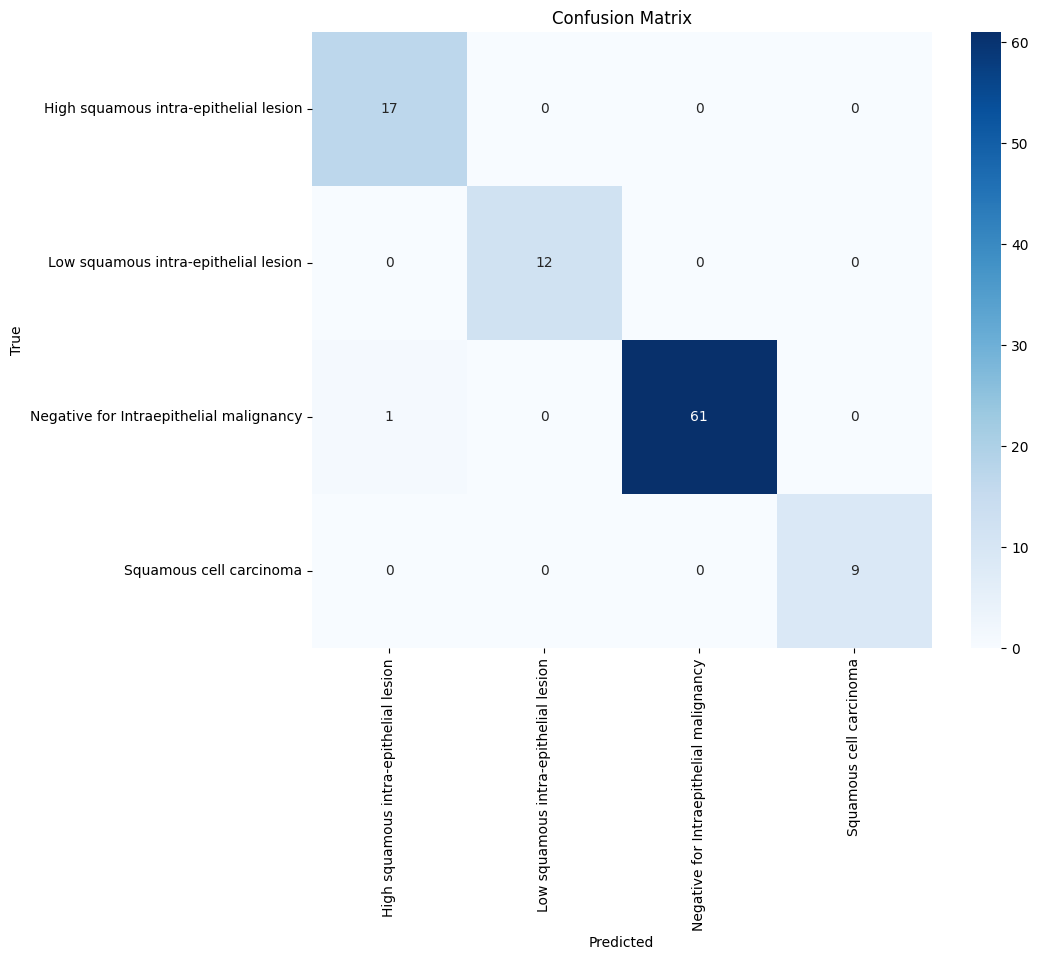

                                     Class  Precision    Recall  F1 Score
0    High squamous intra-epithelial lesion   0.944444  1.000000  0.971429
1     Low squamous intra-epithelial lesion   1.000000  1.000000  1.000000
2  Negative for Intraepithelial malignancy   1.000000  0.983871  0.991870
3                  Squamous cell carcinoma   1.000000  1.000000  1.000000


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)
